### **Reto Final - Parte 1**

* Integrantes: 
  
  * Rafael J. Mateo C -  A01793054
  * Matthias Sibrian - A01794249
  
* Materia: Ciencia y Analítica de Datos
  
* Profesor: María de la Paz
  
* Fecha: 16 Nov 2022

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.base import BaseEstimator, TransformerMixin
import geopandas as gpd
from shapely.geometry import Point
from sklearn import metrics
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer
from sklearn.compose import ColumnTransformer

### **I. Análisis Exploratorio de los Datos**

Comencemos importando los datos que estaremos usando. Para fines de este ejercio, nos apoyaremos de la base de datos de aguas subterráneas.

In [44]:
df = pd.read_csv('datos/aguas_subterraneas_2020.csv')
df.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CA�ADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLAVE                 1068 non-null   object 
 1   SITIO                 1068 non-null   object 
 2   ORGANISMO_DE_CUENCA   1068 non-null   object 
 3   ESTADO                1068 non-null   object 
 4   MUNICIPIO             1068 non-null   object 
 5   ACUIFERO              1068 non-null   object 
 6   SUBTIPO               1068 non-null   object 
 7   LONGITUD              1068 non-null   float64
 8   LATITUD               1068 non-null   float64
 9   PERIODO               1068 non-null   int64  
 10  ALC_mg/L              1064 non-null   float64
 11  CALIDAD_ALC           1064 non-null   object 
 12  CONDUCT_mS/cm         1062 non-null   float64
 13  CALIDAD_CONDUC        1062 non-null   object 
 14  SDT_mg/L              0 non-null      float64
 15  SDT_M_mg/L           

Obtengamos las columnas que tienen valores vacíos y la cantidad de nulos por cada columna

In [46]:
na_columns = df.columns[df.isna().any()].tolist()
na_total = df[na_columns].isna().sum()

pd.DataFrame({'columns': na_columns, 'total': na_total.to_list() })

,columns,total
0,ALC_mg/L,4
1,CALIDAD_ALC,4
2,CONDUCT_mS/cm,6
3,CALIDAD_CONDUC,6
4,SDT_mg/L,1068
5,SDT_M_mg/L,2
6,CALIDAD_SDT_ra,2
7,CALIDAD_SDT_salin,2
8,DUR_mg/L,1
9,CALIDAD_DUR,1


De la tabla anterior se puede apreciar que la columna de Solidos Totales Disueltos (SDT_mg/L) está completamente vacía. La segunda columna con mayor cantidad de nulos es Contaminantes, sin embargo, esta es de esperarse puesto que hay mediciones de agua que no arrojan contaminantes. En otras palabras, un valor nulo en esta columna equivale a ausencia de contaminantes en el agua.

Las demás columnas presentan pocas observaciones nulas. Más adelante definiremos una estrategia para de imputación para estas columnas con valores faltantes.

Del resultado anterior se observa columnas que contienen la misma información pero en tipo de datos diferentes. También hay columnas numéricas detectadas como tipo "object". Vamos a extraer primero todas las columnas categóricas y binarias, ya que son candidatas a ser eliminadas.

Ahora revisemos una de las columnas numéricas que fueron detectadas como object. Tomaremos un ejemplo con Cadmio (CD_TOT_mg/L)

In [47]:
df['CD_TOT_mg/L'].value_counts()

<0.003     1066
0.0056        1
0.03211       1
Name: CD_TOT_mg/L, dtype: int64

De lo anterior se observa que valores muy pequeños son colocados como "<". Para ello, vamos a reemplazar este string por un valor arbitrario por debajo del umbral, de manera que podamos crear una cota inferior y así analizarlo por medio de un histograma o boxplot.

In [48]:
#Definimos las variables numéricas a analizar
vars = [
        'ALC_mg/L','AS_TOT_mg/L', 'CD_TOT_mg/L', 'FE_TOT_mg/L', 'SDT_M_mg/L',
        'SDT_mg/L', 'FLUORUROS_mg/L', 'COLI_FEC_NMP/100_mL', 'CONDUCT_mS/cm', 
        'CR_TOT_mg/L', 'DUR_mg/L', 'HG_TOT_mg/L', 'MN_TOT_mg/L', 'N_NO3_mg/L', 'PB_TOT_mg/L' ]

limits = {}
for  var in vars:
        if  (df[var].dtypes == 'object'):
                #Obtenemos las observaciones que solo tengan < > o =
                limits[var] = df[df[var].str.contains('<|>|=', na='na') == True][var].value_counts().index
#Lo convertimos en DF para mejor visualización
limits_df = pd.DataFrame(limits, index = [0])
display(limits_df.style.hide(axis = 'index'))

AS_TOT_mg/L,CD_TOT_mg/L,FE_TOT_mg/L,SDT_M_mg/L,FLUORUROS_mg/L,COLI_FEC_NMP/100_mL,CR_TOT_mg/L,DUR_mg/L,HG_TOT_mg/L,MN_TOT_mg/L,N_NO3_mg/L,PB_TOT_mg/L
<0.01,<0.003,<0.025,<25,<0.2,<1.1,<0.005,<20,<0.0005,<0.0015,<0.02,<0.005


Se observan que 12 variables tienen valores string. Vamos a proceder sustituir estos strings por valores numéricos.

In [49]:
#Extraemos las columnas que deben ser convertidas de object a float
columns = limits_df.columns

#Hacemos un transpose para que la tabla tenga dos columnas, una con los atributos químicos y otra con sus valores
limits_df = limits_df.transpose()
limits_df = limits_df.reset_index(level = 0)
limits_df.rename(columns={'index': 'attributes', 0:'attr_values'}, inplace= True)

#Extraemos los valores numéricos, eliminando cualquier string (por ej. '<')
limits_df.attr_values = limits_df.attr_values.str.extract('(\d+\.\d+|\d+)')

display(limits_df)
   
   

,attributes,attr_values
0,AS_TOT_mg/L,0.01
1,CD_TOT_mg/L,0.003
2,FE_TOT_mg/L,0.025
3,SDT_M_mg/L,25
4,FLUORUROS_mg/L,0.2
5,COLI_FEC_NMP/100_mL,1.1
6,CR_TOT_mg/L,0.005
7,DUR_mg/L,20
8,HG_TOT_mg/L,0.0005
9,MN_TOT_mg/L,0.0015


In [50]:
#Sustituimos los valores string por un valor float arbitrario, que se encuentre por debajo de lo indicado por la columna
for col in columns:
   val =  (limits_df.loc[limits_df.attributes == col].attr_values.values[0])
   str_match = '<'+ val
   val = float(val)

   df.loc[df[col] == str_match, col] = val -(val/10)
   
   #Convertimos la columna a tipo float
   df[col] = df[col].astype(float)

In [51]:
#Probamos la conversión con una de las columnas
df[['FE_TOT_mg/L']].sort_values(by = 'FE_TOT_mg/L', ascending = False)

,FE_TOT_mg/L
425,178.6150
331,16.4371
9,14.0600
799,13.4400
561,7.3820
...,...
675,0.0225
672,0.0225
671,0.0225
670,0.0225


Ahora procedamos a revisar los valores únicos para cada variable numérica. Esto nos ayudará a decidir si valdría la pena usar la versión binaria o categórica en vez de alguna variable numérica.

In [52]:
uniques = {'attributes': [], 'unique_vals': []}
for col in vars:
    uniques['attributes'].append(col) 
    uniques['unique_vals'].append(df[col].unique().size)
    
pd.DataFrame(uniques)

,attributes,unique_vals
0,ALC_mg/L,817
1,AS_TOT_mg/L,209
2,CD_TOT_mg/L,3
3,FE_TOT_mg/L,615
4,SDT_M_mg/L,926
5,SDT_mg/L,1
6,FLUORUROS_mg/L,862
7,COLI_FEC_NMP/100_mL,125
8,CONDUCT_mS/cm,802
9,CR_TOT_mg/L,168


De la tabla anterior, el atributo Solidos Disueltos Totales (SDT_mg/L) está completamente vacío y por eso aparece que tiene solo un valor único, como veremos más adelante. En el caso de Cadmio (CD_TOT), este tiene apenas 3 valores únicos. Revisemos cuáles son estos valores.

In [53]:
df['CD_TOT_mg/L'].value_counts()

0.00270    1066
0.00560       1
0.03211       1
Name: CD_TOT_mg/L, dtype: int64

De lo anterior se puede apreciar que casi el 100% de las observaciones caen dentro del rango aceptable (<0.003), mientras que los otros dos valores no cumplen con el parámetro requerido (>0.005). Esto significa que podríamos perfectamente usar la variable binaria correspondiente a este atributo, ya que la información proporcionada es exactamente la misma.

Ahora revisemos la correlación entre cada una de las variables del conjunto de datos.

<AxesSubplot: >

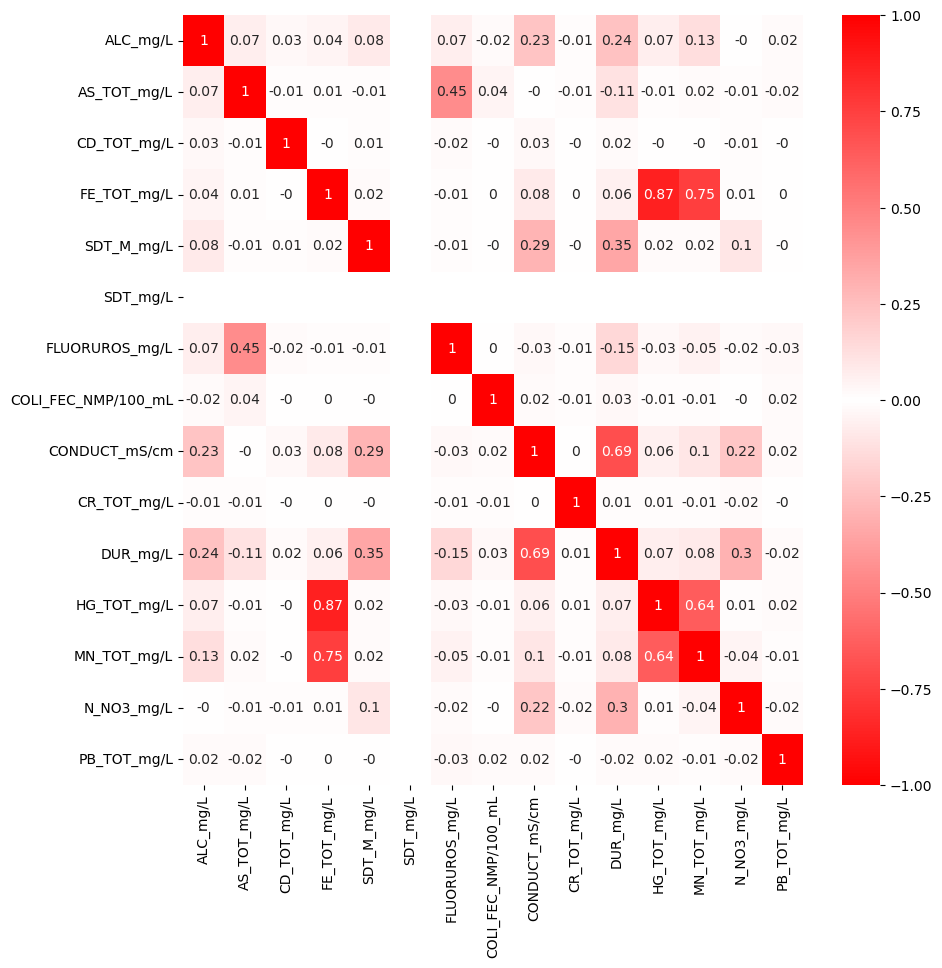

In [54]:
cmap = LinearSegmentedColormap.from_list(
    name='test', 
    colors=['red','white','red'])
plt.figure(figsize=(10,10))
sns.heatmap(np.round(df[vars].corr(), 2), annot=True, cmap = cmap, vmin = -1.0, vmax = 1.0)

Para realizar el análisis de correlación, usaremos como umbral para definir correlación fuerte aquellas variables que tengan un coeficiente >= 0.75. Basado en este criterio, podemos observar que tres variables están altamente correlacionadas:

* Mercurio (HG)
* Manganeso (MN)
* Hierro (FE)

In [55]:
df[['HG_TOT_mg/L', 'MN_TOT_mg/L', 'FE_TOT_mg/L']].isna().any()

HG_TOT_mg/L    False
MN_TOT_mg/L    False
FE_TOT_mg/L    False
dtype: bool

Ahora revisemos los campos vacíos de las demás variables que no tienen una correlación alta, basada en el criterio definido arriba

In [56]:
na_columns = df.columns[df.isna().any()].tolist()
na_total = df[na_columns].isna().sum()

pd.DataFrame({'columns': na_columns, 'total': na_total.to_list() })

,columns,total
0,ALC_mg/L,4
1,CALIDAD_ALC,4
2,CONDUCT_mS/cm,6
3,CALIDAD_CONDUC,6
4,SDT_mg/L,1068
5,SDT_M_mg/L,2
6,CALIDAD_SDT_ra,2
7,CALIDAD_SDT_salin,2
8,DUR_mg/L,1
9,CALIDAD_DUR,1


De la tabla anterior se aprecia que ninguna de las variables altamente correlacionadas cuentan con campos vacíos. También se puede observar que variables con una correlación relativamente alta, como Conductividad y Dureza (coef = 0.69), cuentan con campos vacíos. Para estas dos variables podríamos apoyarnos de la información de la correlación para definir una estrategia de imputación.

En el caso de la variable "SDT_mg/L", esta se encuentra completamente vacía, sin embargo, esta tiene una relación directa con la conductividad del agua, donde puede ser calculada con la siguiente fórmula: (https://iwaponline.com/wst/article/77/8/1998/38602/Relationship-between-total-dissolved-solids-and):

TDS (mg/L) = Ke x EC(uS/cm)

donde Ke es un factor que normalmente varía entre 0.55 a 0.85 y EC es la conductividad del agua.

Como la relación de los sólidos totales disueltos es directamente proporcional a la conductividad del agua, esta variable puede ser eliminada para fines de entrenar el modelo, ya que estaría altamente correlacionada con la conductividad, y por ende proporcionar la misma información para el modelo.

Por otro lado, la segunda columna con mayor cantidad de nulos es Contaminantes, sin embargo, esta es de esperarse puesto que hay mediciones de agua que no arrojan contaminantes. En otras palabras, un valor nulo en esta columna equivale a ausencia de contaminantes en el agua.

Las demás columnas presentan pocas observaciones nulas.

**Conclusiones de esta sección**

De esta sección concluimos lo siguiente:

1. Las columnas de Mercurio, Manganeso están altamente correlacionadas con Hierro, por lo que podemos eliminar dos de ellas. Para este caso, nos quedaremos solamente con la columna de Hierro.
2. La variable "SDT_mg/L" tiene todos los campos vacíos, sin embargo, este valor es directamente proporcional a la conductividad. En este sentido, podemos eliminar esta columna ya que estaría altamente correlacionada con la conductividad.
3. La variable "Contaminantes" puede ser eliminada, ya que esto solo indica los contaminantes cuando el agua no es apta para su uso. Esta información no agregaría valor al modelo.
4. La variable "CD_TOT" solo tiene dos valores únicos, por lo que puede eliminarse y reemplazarse en su lugar por su variable binaria correspondiente (CUMPLE_CON_CD).
5. Las demás variables binarias y categóricas pueden ser eliminadas ya que se estarán utilizando las variables numéricas en su lugar.


En la próxima sesión definiremos la estrategia de imputación.

### **II. Estrategia de Imputación**

En esta sección definiremos la mejor manera de imputar los datos vacíos y nulos. Para ello comencemos primero con las variables "Conductividad" y "Dureza", las cuales mostraron una correlación relativamente alta en la sección anterior.

Comencemos primero revisando que porcentaje de las variables "CUMPLE_CON_COND" y "CUMPLE_CON_DUR" coincide en sus valores. Debido a la correlación de 0.69 obtenida en la sección anterior, es de esperarse que un alto porcentaje coincida.

Ahora procederemos a definir las columnas que estaremos eliminado, como concluímos en la sección #1.

In [57]:
cols_to_drop= ['CLAVE', 'SITIO', 'CONTAMINANTES', 'ORGANISMO_DE_CUENCA', 'PERIODO', 
                     'CD_TOT_mg/L', 'ACUIFERO', 'MUNICIPIO', 'SDT_mg/L', 'ESTADO']

df_final_cols = df.drop(cols_to_drop, axis = 1)

In [58]:
bin_vars =  df.columns[df.columns.str.contains('CUMPLE')].to_list()
cat_vars = df.columns[df.columns.str.contains('CALIDAD')].to_list() + ['LONGITUD', 'LATITUD', 'SUBTIPO', 'SEMAFORO']
num_vars = df_final_cols.drop(cat_vars + bin_vars, axis = 1).columns.to_list()

print(f'Numeric variables: {num_vars}\n')
print(f'Categorical variables: {cat_vars}\n')
print(f'Binary variables: {bin_vars}')

Numeric variables: ['ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_M_mg/L', 'FLUORUROS_mg/L', 'DUR_mg/L', 'COLI_FEC_NMP/100_mL', 'N_NO3_mg/L', 'AS_TOT_mg/L', 'CR_TOT_mg/L', 'HG_TOT_mg/L', 'PB_TOT_mg/L', 'MN_TOT_mg/L', 'FE_TOT_mg/L']

Categorical variables: ['CALIDAD_ALC', 'CALIDAD_CONDUC', 'CALIDAD_SDT_ra', 'CALIDAD_SDT_salin', 'CALIDAD_FLUO', 'CALIDAD_DUR', 'CALIDAD_COLI_FEC', 'CALIDAD_N_NO3', 'CALIDAD_AS', 'CALIDAD_CD', 'CALIDAD_CR', 'CALIDAD_HG', 'CALIDAD_PB', 'CALIDAD_MN', 'CALIDAD_FE', 'LONGITUD', 'LATITUD', 'SUBTIPO', 'SEMAFORO']

Binary variables: ['CUMPLE_CON_ALC', 'CUMPLE_CON_COND', 'CUMPLE_CON_SDT_ra', 'CUMPLE_CON_SDT_salin', 'CUMPLE_CON_FLUO', 'CUMPLE_CON_DUR', 'CUMPLE_CON_CF', 'CUMPLE_CON_NO3', 'CUMPLE_CON_AS', 'CUMPLE_CON_CD', 'CUMPLE_CON_CR', 'CUMPLE_CON_HG', 'CUMPLE_CON_PB', 'CUMPLE_CON_MN', 'CUMPLE_CON_FE']


In [59]:
#Al existir una alta correlación entre conductividad y dureza, las columnas de cumplimiento coinciden en casi el 85% de las veces. Se podría imputar una de estas columna con el valor correspondiente de la otra
len(df[df['CUMPLE_CON_COND'] == df['CUMPLE_CON_DUR']])/len(df)

0.849250936329588

Cerca de 85% de las observaciones tienen valores iguales entre las columnas de "CUMPLE_CON_COND" y "CUMPLE_CON_DUR", como era de esperarse. Esta información podemos usarla para definir una estrategia de imputación personalizada, tanto para dureza como conductividad.

In [60]:
class WaterFeaturesImputer (TransformerMixin, BaseEstimator):
    
    def __transformHardness(self, X):
               
        X.loc[(X['DUR_mg/L'].isna()) & (X['CUMPLE_CON_COND'] == 'SI'),'DUR_mg/L'] = \
            X[X['CUMPLE_CON_COND'] == 'SI']['DUR_mg/L'].median()
            
        X.loc[(X['DUR_mg/L'].isna()) & (X['CUMPLE_CON_COND'] == 'NO'),'DUR_mg/L'] = \
            X[X['CUMPLE_CON_COND'] == 'NO']['DUR_mg/L'].median()
        
        return X
        
    def __transformConductivity(self, X):
                
        X.loc[(X['CONDUCT_mS/cm'].isna()) & (X['CUMPLE_CON_DUR'] == 'SI'),'CONDUCT_mS/cm'] = \
            X[X['CUMPLE_CON_DUR'] == 'SI']['CONDUCT_mS/cm'].median()
            
        X.loc[(X['CONDUCT_mS/cm'].isna()) & (X['CUMPLE_CON_DUR'] == 'NO'),'CONDUCT_mS/cm'] = \
            X[X['CUMPLE_CON_DUR'] == 'NO']['CONDUCT_mS/cm'].median()
        
        return X
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        
        X_copy = X.copy()
        
        X_copy = self.__transformHardness(X_copy)
        X_copy = self.__transformConductivity(X_copy)
        
        X_copy = X_copy.drop(['CUMPLE_CON_DUR', 'CUMPLE_CON_COND'], axis = 1)
        
        X_copy = X_copy[num_vars].fillna(X_copy[num_vars].median())
        
        return X_copy

Probemos que el imputador funciona

In [61]:
impt = WaterFeaturesImputer()
df.dtypes
res = impt.transform(df)

res['CONDUCT_mS/cm'].isna().sum()

0

In [62]:
res['DUR_mg/L'].isna().sum()

0

In [63]:
#Para fines del análisis descriptivo, sacamos Longitud y Latitud, ya que estas variables son identificadores
df_final_cols.drop(['LONGITUD', 'LATITUD'], axis = 1).describe()

,ALC_mg/L,CONDUCT_mS/cm,SDT_M_mg/L,FLUORUROS_mg/L,DUR_mg/L,COLI_FEC_NMP/100_mL,N_NO3_mg/L,AS_TOT_mg/L,CR_TOT_mg/L,HG_TOT_mg/L,PB_TOT_mg/L,MN_TOT_mg/L,FE_TOT_mg/L
count,1064.000000,1062.000000,1066.000000,1068.000000,1067.000000,1068.000000,1067.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000,1068.000000
mean,235.633759,1138.953013,896.099221,1.072566,347.889338,355.414448,4.319637,0.018855,0.012876,0.000512,0.004796,0.072401,0.409449
std,116.874291,1245.563674,2751.531334,1.925673,359.714059,2052.470134,8.345197,0.035420,0.154413,0.000473,0.003297,0.376527,5.538039
min,26.640000,50.400000,22.500000,0.180000,18.000000,0.990000,0.018000,0.009000,0.004500,0.000450,0.004500,0.001350,0.022500
25%,164.000000,501.750000,337.500000,0.267175,121.194800,0.990000,0.650294,0.009000,0.004500,0.000450,0.004500,0.001350,0.022500
50%,215.527500,815.000000,550.400000,0.503500,245.335800,0.990000,2.080932,0.009000,0.004500,0.000450,0.004500,0.001350,0.046960
75%,292.710000,1322.750000,916.100000,1.139850,453.930000,13.250000,5.201698,0.009000,0.004500,0.000450,0.004500,0.009947,0.173380
max,1650.000000,18577.000000,82170.000000,34.803300,3810.692200,24196.000000,121.007813,0.452200,5.003200,0.014150,0.080900,8.982000,178.615000


Si bien la mayoría de las variables tienen la misma unidad de medida, sus valores umbrales para definir la calidad del agua son diferentes. Por ejemplo, dureza debe ser menor < 60 mg/L, mientras que los nitratos deben estar por debajo de 5 mg/L y el mercurio por debajo de 0.006 mg/L. Esto significa que sería importante aplicar un escalamiento, para evitar que el modelo a entrenar de más peso a una variable que otra.

Otro aspecto a destacar del análisis descriptivo es la presencia de valores atípicos. Por ejemplo, la dureza tiene un valir máximo de 3,810, cuando su media es de 346 y su mediana de 241.

Hagamos un análisis gráfico de las variables para revisar su distribución y comportamiento.

In [64]:
cols_to_plot = df_final_cols.drop(cat_vars, axis = 1).columns

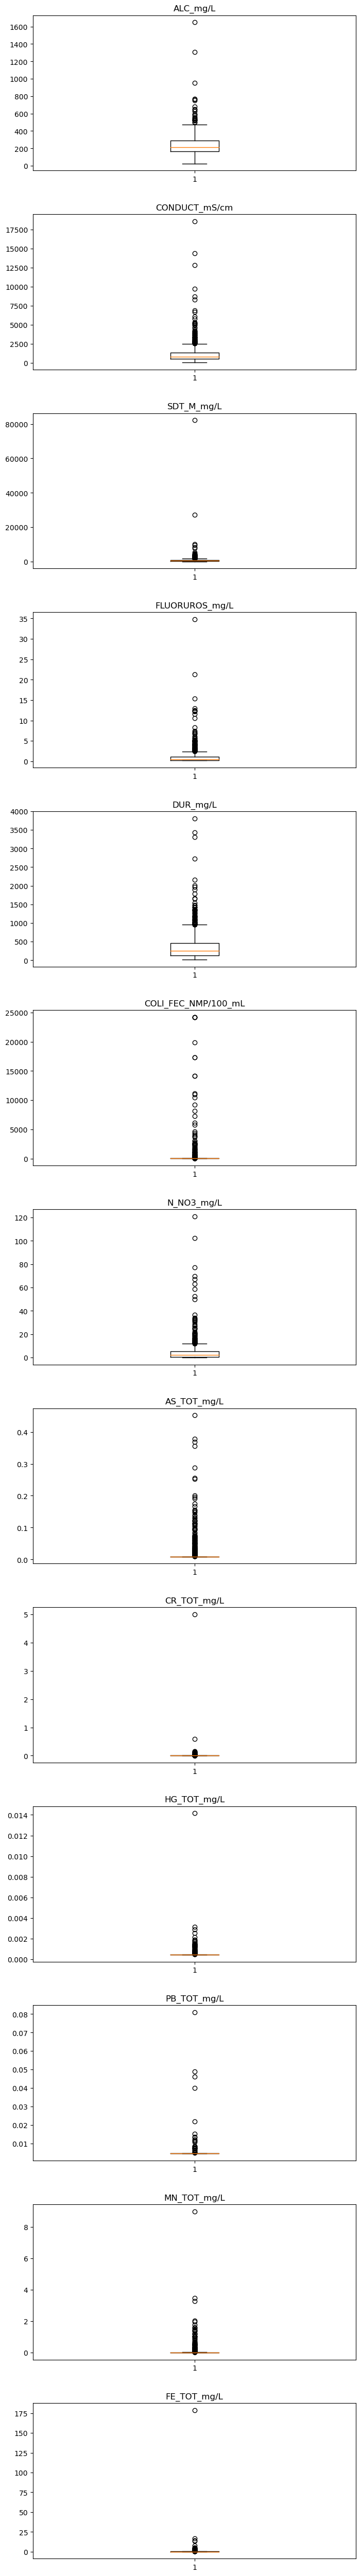

In [65]:
fig, axes = plt.subplots(13)
fig.set_size_inches(7,50)
plt.tight_layout(h_pad = 4)

count = 0

for i in range(13):
        axes[i].boxplot(df_final_cols[num_vars[i]].dropna())
        axes[i].set_title(num_vars[i])
     

De los diagramas de cajas presentados arriba se confirma la presencia de valores atípicos para todas las variables numéricas. Esto representa un problema para el algoritmo K-means, puesto a que es sensible a valores atípicos. Sin embargo, para modelos de clasificación como Árboles de Decisión o Random Forest, la presencia de los atípicos no suponen un problema para estos modelos. Como veremos más adelante, para minimizar el efecto de los atípicos estaremos usando la función "Normalizer" de la librería.

Ahora veamos la composición de la variable de salida 'SEMAFORO'



In [66]:
(df_final_cols.SEMAFORO.value_counts()/len(df_final_cols)) * 100

Verde       40.636704
Rojo        36.235955
Amarillo    23.127341
Name: SEMAFORO, dtype: float64

Del análisis anterior se evidencia que la clase 'Amarillo' se encuentra ligeramente subrepresentada. Sin embargo, una representación equitativa de cada clase equivaldría a un 33%, por lo que tampoco se encuentra muy lejos de este valor.

Para fines de este ejercicio no tomaríamos en cuenta estrategias para balanceo de clases por lo explicado arriba.

#### **III. Generación de Clústers por Kmeans**

En esta sección estaremos agrupando las observaciones por clústers, a través del algortimo de KMeans. La agrupación de las observaciones la haremos de la siguiente manera:

1. Por variables numéricas. Por medio de esta estrategia veremos si el algoritmo kmeans encuentra algún patrón de agrupamiento de las observaciones. Para esto debemos tomar en cuenta que los datos deben escalarse, ya que existen atípicos que pueden afectar el desempeño de este algoritmo, como vimos en la sección anterior.
   
2. Por coordenadas. Esto nos permitirá obtener obtener los centros de cada clúster y visaulizarlos en el mapa, y a partir de ahí obtener la moda del semáforo de cada centro para conocer cuál de estos valores es el que predomina para cada clúster.

**3.1. Kmeans por variables numéricas**

Comencemos primero creando los pipelines para imputar y transformar los datos que estaremos usando para el kmeans. Debido a la presencia de atípicos, estaremos usando "Normalizer" para buscar que los atípicos se encuentren en una misma escala, así como buscar una distribución más uniforme.

Existen otros métodos de escalamiento de datos, como el MinMaxScaler y StandardScaler, sin embargo, estos son sensibles a valores atípicos extremos.

In [67]:
catImp_pipeline = Pipeline(steps = [('impModa', SimpleImputer(strategy='most_frequent'))])
custom_pipeline = Pipeline(steps=[
    ('hardness-imputer', WaterFeaturesImputer()),
    ('scaler', Normalizer())    
])  

columnasTransformer = ColumnTransformer(transformers = [
    ('catimp', catImp_pipeline, cat_vars + bin_vars),
    ('custom-imp', custom_pipeline, (num_vars + ['CUMPLE_CON_COND', 'CUMPLE_CON_DUR'])),
   ],
    remainder='drop')

												
									
pipeline = Pipeline(
    steps=[
        ('ct', columnasTransformer),        
        ])

scaled_f = pipeline.fit_transform(df)

#Imprimimos una muestra de los datos transformados
scaled_f[:3,:]

array([['Alta', 'Permisible para riego', 'Cultivos sensibles',
        'Potable - Dulce', 'Potable - Optima', 'Potable - Dura',
        'Potable - Excelente', 'Potable - Excelente', 'Apta como FAAP',
        'Potable - Excelente', 'Potable - Excelente',
        'Potable - Excelente', 'Potable - Excelente',
        'Potable - Excelente', 'Potable - Excelente', -102.0221,
        22.20887, 'POZO', 'Verde', 'SI', 'SI', 'SI', 'SI', 'SI', 'SI',
        'SI', 'SI', 'SI', 'SI', 'SI', 'SI', 'SI', 'SI', 'SI',
        0.19819882176400136, 0.8100651874349375, 0.5201652629103493,
        0.0008416060234563403, 0.1841881411072809, 0.0008531537612346682,
        0.0036062171776497193, 1.387452076351329e-05,
        3.877971641975765e-06, 3.877971641975764e-07,
        3.877971641975765e-06, 1.1633914925927293e-06,
        7.678383851112013e-05],
       ['Alta', 'Buena para riego', 'Excelente para riego',
        'Potable - Dulce', 'Potable - Optima', 'Potable - Dura',
        'Potable - Excelente', 

Veamos como quedaron los datos luego de ser escalados

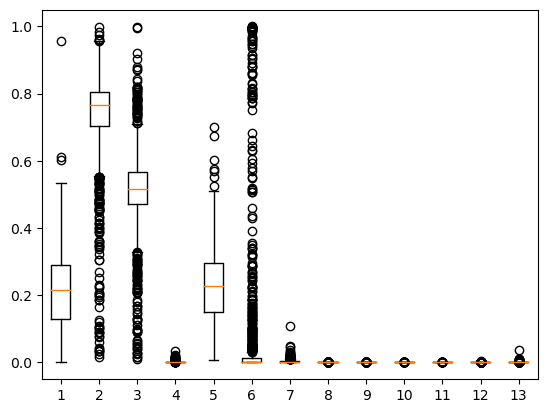

In [68]:
plt.boxplot(x = ((scaled_f[:,34:])))
plt.show()

Aún se observan la presencia de atípicos, sin embargo, estos se encuentran en la misma escala, el cual es el resultado que queremos. Ahora procedamos a generar el número óptimo de clústeres, tanto por el método del codo como por el método de siluetas.

Text(0.5, 1.0, 'K-Means: Gráfica de codo')

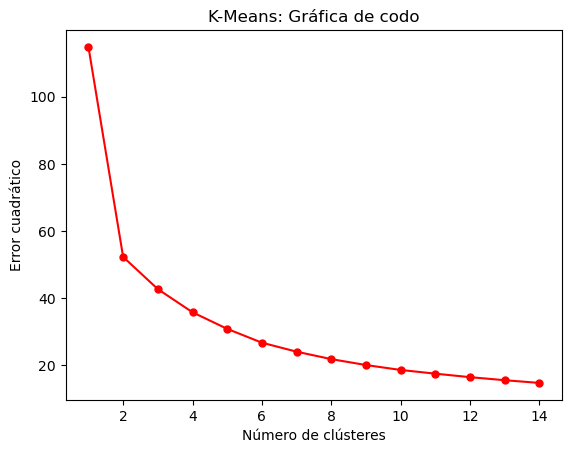

In [69]:
from sklearn.cluster import KMeans
K = range(1,15)

wss = []

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    
    kmeans = kmeans.fit(scaled_f[:,34:])
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

centers = pd.DataFrame({'Clusters': K, 'WSS': wss})

import seaborn as sns
plt.plot(centers.Clusters, centers.WSS, 'ro-', markersize = 5)
plt.xlabel('Número de clústeres')
plt.ylabel('Error cuadrático')
plt.title('K-Means: Gráfica de codo')

In [70]:
#Empezamos a partir del segundo clúster
for i in range(2,10):
    #Entrenamos nuevamente el modelo para obtener el score de cada uno de ellos
    labels=KMeans(n_clusters=i,init="k-means++",random_state=200).fit(scaled_f[:,34:]).labels_
    #Imprimimos las métricas
    print ("Silhouette score for k(clusters) = "+str(i)+" is "
           +str(
               metrics.silhouette_score(
                   scaled_f[:,34:],labels,
                   metric="euclidean",
                   sample_size=1000,random_state=200))) 

Silhouette score for k(clusters) = 2 is 0.7285495977148867
Silhouette score for k(clusters) = 3 is 0.3277586102705237
Silhouette score for k(clusters) = 4 is 0.24639306498983482
Silhouette score for k(clusters) = 5 is 0.2554126446100517
Silhouette score for k(clusters) = 6 is 0.2617335482584944
Silhouette score for k(clusters) = 7 is 0.26267633228091436
Silhouette score for k(clusters) = 8 is 0.2653528506055504
Silhouette score for k(clusters) = 9 is 0.2565633266250199


Tanto el método del codo como el método de siluetas coinciden en que el número óptimo de clústers es de 2. Tomemos esta información para el modelo final.

In [71]:

k = 2 #Número óptimo de clústers
kmeans = KMeans(n_clusters = k, init ='k-means++')

kmeans.fit(scaled_f[:,34:])

#Asignamos cada clúster a nuestros datos
df_final_cols['labels'] = kmeans.labels_
df_final_cols['labels'].head()


0    0
1    0
2    0
3    0
4    0
Name: labels, dtype: int32

In [72]:
#Obtengamos los mapas
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

#Generemos las coordenadas
df_final_cols["Coordinates"] = list(zip(df_final_cols.LONGITUD, df_final_cols.LATITUD))
df_final_cols["Coordinates"] = df_final_cols["Coordinates"].apply(Point)

#Construimos el dataframe
gdf = gpd.GeoDataFrame(df_final_cols, geometry="Coordinates")

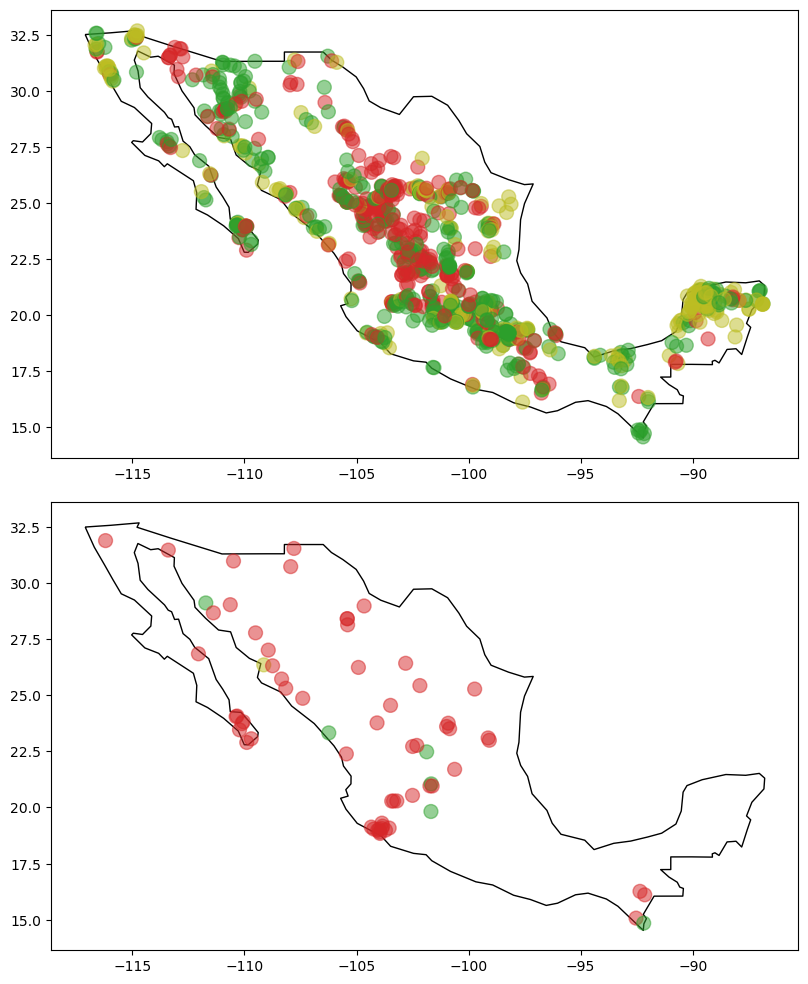

In [73]:
#Generamos un mapeo de los colores
color_map = {
    'Verde': 'tab:green',
    'Rojo': 'tab:red',
    'Amarillo': 'tab:olive'
}

fig, gax = plt.subplots(k, figsize=(10,10))
plt.tight_layout()

#Generamos un mapa por clúster para mejor visibilidad de los puntos
for i in range(k):
  
    #Graficamos el mapa de México
    world.query("name == 'Mexico'").plot(ax = gax[i], edgecolor='black', color='white')
    #Graficamos los puntos
    gdf[gdf.labels == i].plot(ax=gax[i], color=df[gdf.labels == i].SEMAFORO.map(color_map), 
                              markersize=100, marker='o', alpha = 0.5, aspect = 'equal')

plt.show()

En el gráfico anterior llama la atención que el clúster #2 se compone mayormente de pozos donde la calidad del agua está contaminada. En el caso del clúster 1 se observa que este contiene pozos con una calidad de agua mixta, tanto potable como contaminada.

Veamos los datos más de cerca para entender mejor las diferencias entre estos dos clústers. Para esto generaremos estadísticas descriptiva por atributo y por clúster.

In [74]:
for var in num_vars:
    #Estadísticos que nos interesa analizar
    dicc  = {'mean':[], 'median': [], 'std': [], 'min': [], 'max':[], 'mode':[]}
    for i in range(k):
        #Obtenemos las observaciones correspndiente al clúster y variable
        col = df_final_cols[df_final_cols['labels'] == i][var]
        
        #Generamos los estadísticos
        dicc['mean'].append(col.mean())
        dicc['median'].append(col.median())
        dicc['std'].append(col.std())
        dicc['min'].append(col.min())
        dicc['max'].append(col.max())
        dicc['mode'].append(col.mode()[0])
        
    print(var)
    display(pd.DataFrame(dicc, index = ['Cluster 1', 'Cluster 2']))

ALC_mg/L


,mean,median,std,min,max,mode
Cluster 1,236.433225,215.715,118.889253,26.64,1650.00,157.62
Cluster 2,223.737239,211.335,80.896427,89.38,455.52,168.72


CONDUCT_mS/cm


,mean,median,std,min,max,mode
Cluster 1,1151.089246,830.0,1269.357431,50.4,18577.0,777.0
Cluster 2,958.720896,731.0,799.075171,226.0,4960.0,495.0


SDT_M_mg/L


,mean,median,std,min,max,mode
Cluster 1,910.802506,556.0,2837.892147,22.5,82170.0,292.0
Cluster 2,676.866667,491.6,578.320845,151.6,3299.0,188.0


FLUORUROS_mg/L


,mean,median,std,min,max,mode
Cluster 1,1.078019,0.5163,1.935708,0.18,34.8033,0.18
Cluster 2,0.991093,0.3326,1.780481,0.18,12.5010,0.18


DUR_mg/L


,mean,median,std,min,max,mode
Cluster 1,349.086883,245.66235,361.451718,18.0,3810.6922,18.0
Cluster 2,330.015522,233.06400,334.724789,18.0,1649.9300,18.0


COLI_FEC_NMP/100_mL


,mean,median,std,min,max,mode
Cluster 1,36.649980,0.99,147.205160,0.99,2247.0,0.99
Cluster 2,5117.850746,2400.00,6573.459933,430.00,24196.0,2400.00


N_NO3_mg/L


,mean,median,std,min,max,mode
Cluster 1,4.366361,2.063471,8.564357,0.018,121.007813,0.018
Cluster 2,3.622269,2.241700,3.751902,0.018,18.525663,0.018


AS_TOT_mg/L


,mean,median,std,min,max,mode
Cluster 1,0.018827,0.009,0.034536,0.009,0.4522,0.009
Cluster 2,0.019270,0.009,0.047013,0.009,0.3558,0.009


CR_TOT_mg/L


,mean,median,std,min,max,mode
Cluster 1,0.013374,0.0045,0.159487,0.0045,5.0032,0.0045
Cluster 2,0.005426,0.0045,0.003360,0.0045,0.0256,0.0045


HG_TOT_mg/L


,mean,median,std,min,max,mode
Cluster 1,0.000514,0.00045,0.000487,0.00045,0.01415,0.00045
Cluster 2,0.000479,0.00045,0.000157,0.00045,0.00149,0.00045


PB_TOT_mg/L


,mean,median,std,min,max,mode
Cluster 1,0.004694,0.0045,0.002588,0.0045,0.0809,0.0045
Cluster 2,0.006312,0.0045,0.008471,0.0045,0.0490,0.0045


MN_TOT_mg/L


,mean,median,std,min,max,mode
Cluster 1,0.072710,0.00135,0.384275,0.00135,8.982,0.00135
Cluster 2,0.067798,0.00530,0.233624,0.00135,1.477,0.00135


FE_TOT_mg/L


,mean,median,std,min,max,mode
Cluster 1,0.405031,0.0460,5.702692,0.0225,178.615,0.0225
Cluster 2,0.475451,0.0678,1.757041,0.0225,14.060,0.0225


De lo anterior puede apreciarse lo siguiente:

* Para la mayoría de los atributos, el clúster 2 posee una desviación estándar más pequeña. Es de esperarse, puesto que este clúster tiene menos cantidad de observaciones.
* La variable Coliformes Fecales (COLI_FEC_NMP/100_mL) es la que presenta valores más alto para el clúster #2. También se observa que su moda es de 2,400 NMP/100ML, muy por encima de los valores aceptables, el cual es de 1000 NMP/100ML.
* Los demás atributos se encuentran en un rango de excelente (potable) a aceptable. 
 
De lo anterior se podría sospechar que la variable que mayor impacto tuvo en la división de los clústeres fue los Coliformes Fecales. Revisemos esta hipótesis más de cerca, pero ahora analizando las variables binarias.

In [75]:
#Definimos las variables que nos interesa analizar
vars = ['CUMPLE_CON_ALC', 'CUMPLE_CON_COND', 'CUMPLE_CON_SDT_ra',
       'CUMPLE_CON_SDT_salin', 'CUMPLE_CON_FLUO', 'CUMPLE_CON_DUR',
       'CUMPLE_CON_CF', 'CUMPLE_CON_NO3', 'CUMPLE_CON_AS', 'CUMPLE_CON_CD',
       'CUMPLE_CON_CR', 'CUMPLE_CON_HG', 'CUMPLE_CON_PB', 'CUMPLE_CON_MN',
       'CUMPLE_CON_FE']

for var in vars:
    dicc  = {'% Cumple':[], '% Verde': [], '% Amarillo': [], '% Rojo': []}
    for i in range(k):
        col = df_final_cols[df_final_cols['labels'] == i][var]
        
        #Calculamos los porcentajes de cumplimiento
        dicc['% Verde'].append((col[df_final_cols['SEMAFORO'] == 'Verde'].count() / len(col))*100)
        dicc['% Amarillo'].append((col[df_final_cols['SEMAFORO'] == 'Amarillo'].count() / len(col)) * 100)
        dicc['% Rojo'].append((col[df_final_cols['SEMAFORO'] == 'Rojo'].count() / len(col)) * 100)
        dicc['% Cumple'].append((col[df_final_cols[var] == 'SI'].count() / len(col))*100)
        
    #Imprimimos los resultados
    print(var)
    display(pd.DataFrame(dicc, index = ['Cluster 1', 'Cluster 2']))

CUMPLE_CON_ALC


,% Cumple,% Verde,% Amarillo,% Rojo
Cluster 1,93.806194,42.757243,24.575425,32.667333
Cluster 2,98.507463,8.955224,1.492537,89.552239


CUMPLE_CON_COND


,% Cumple,% Verde,% Amarillo,% Rojo
Cluster 1,87.512488,42.757243,24.575425,32.667333
Cluster 2,94.029851,8.955224,1.492537,89.552239


CUMPLE_CON_SDT_ra


,% Cumple,% Verde,% Amarillo,% Rojo
Cluster 1,93.006993,42.757243,24.575425,32.667333
Cluster 2,95.522388,8.955224,1.492537,89.552239


CUMPLE_CON_SDT_salin


,% Cumple,% Verde,% Amarillo,% Rojo
Cluster 1,93.006993,42.757243,24.575425,32.667333
Cluster 2,95.522388,8.955224,1.492537,89.552239


CUMPLE_CON_FLUO


,% Cumple,% Verde,% Amarillo,% Rojo
Cluster 1,81.718282,42.757243,24.575425,32.667333
Cluster 2,86.567164,8.955224,1.492537,89.552239


CUMPLE_CON_DUR


,% Cumple,% Verde,% Amarillo,% Rojo
Cluster 1,78.221778,42.757243,24.575425,32.667333
Cluster 2,86.567164,8.955224,1.492537,89.552239


CUMPLE_CON_CF


,% Cumple,% Verde,% Amarillo,% Rojo
Cluster 1,99.400599,42.757243,24.575425,32.667333
Cluster 2,17.910448,8.955224,1.492537,89.552239


CUMPLE_CON_NO3


,% Cumple,% Verde,% Amarillo,% Rojo
Cluster 1,92.007992,42.757243,24.575425,32.667333
Cluster 2,95.522388,8.955224,1.492537,89.552239


CUMPLE_CON_AS


,% Cumple,% Verde,% Amarillo,% Rojo
Cluster 1,87.712288,42.757243,24.575425,32.667333
Cluster 2,94.029851,8.955224,1.492537,89.552239


CUMPLE_CON_CD


,% Cumple,% Verde,% Amarillo,% Rojo
Cluster 1,99.900100,42.757243,24.575425,32.667333
Cluster 2,98.507463,8.955224,1.492537,89.552239


CUMPLE_CON_CR


,% Cumple,% Verde,% Amarillo,% Rojo
Cluster 1,98.501499,42.757243,24.575425,32.667333
Cluster 2,100.000000,8.955224,1.492537,89.552239


CUMPLE_CON_HG


,% Cumple,% Verde,% Amarillo,% Rojo
Cluster 1,99.9001,42.757243,24.575425,32.667333
Cluster 2,100.0000,8.955224,1.492537,89.552239


CUMPLE_CON_PB


,% Cumple,% Verde,% Amarillo,% Rojo
Cluster 1,99.100899,42.757243,24.575425,32.667333
Cluster 2,95.522388,8.955224,1.492537,89.552239


CUMPLE_CON_MN


,% Cumple,% Verde,% Amarillo,% Rojo
Cluster 1,92.007992,42.757243,24.575425,32.667333
Cluster 2,91.044776,8.955224,1.492537,89.552239


CUMPLE_CON_FE


,% Cumple,% Verde,% Amarillo,% Rojo
Cluster 1,87.712288,42.757243,24.575425,32.667333
Cluster 2,80.597015,8.955224,1.492537,89.552239


De la tabla mostrada arriba se puede observar que la variable Coliforme Fecales es la que tiene el % de cumplimiento más bajo (18%) para el clúster #2, lo cual coincide con el análisis descriptivo realizado anteriormente.

Esto significa que el kmeans está agrupando en función de la contaminación debida a los Coliformes Fecales, por lo que los puntos graficados en el mapa serían aquellos pozos con mayor contaminación por coliformes.

Generemos nuevamente el mapa del clúster dos para hacer un análisis más detallado.

<AxesSubplot: >

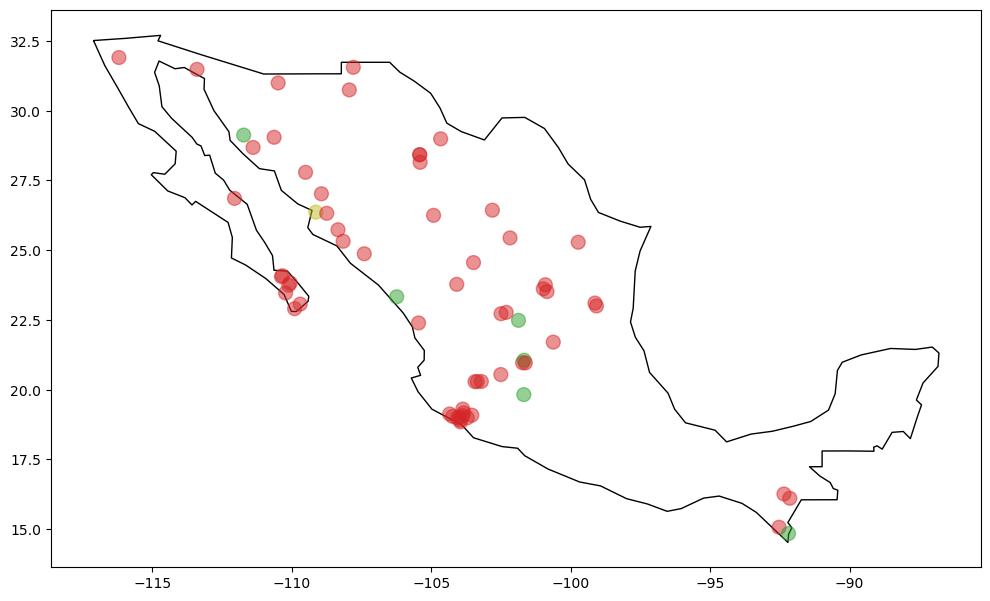

In [76]:
fig, gax = plt.subplots(figsize=(12,10))

world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')
    #Graficamos los puntos
gdf[gdf.labels == 1].plot(ax = gax,color=df_final_cols[gdf.labels == 1].SEMAFORO.map(color_map), 
                              markersize=100, marker='o', alpha = 0.5, aspect = 'equal')

Ya sabemos que los puntos rojos se deben en su mayoría a valores altos de coliformes fecales, por lo que conlleva a que estas aguas estén contaminadas. Del mapa anterior se puede destacar lo siguiente:

* Existen algunos cúmulos de puntos en los estados de Baja California Sur y Colima, lo cual significa que cuentan con varios números de pozos altamente contaminados por coliformes fecales. De hecho, si se compara con el mapa del clúster 1, se puede apreciar que de corregir esta situación estos dos estados tendrían la mayoría de sus pozos con una calidad entre excelente y aceptable.
* También se destacan varios pozos contaminados entre el sur de Sonora y el norte de Sinaloa. En comparación con el mapa del clúster 1, también se observa que la mayoría de los puntos rojos se debe a contaminación por coliformes.
* La parte sur de méxico prácticamente no tiene pozos contaminados, a excepción de aquellos que se encuentran por la zona de Chiapas.


Para un ejercicio futuro, podría ser interesante correlacionar esta información con datos demográficos de los estados mencionados.

**3.2. Kmeans por coordenadas**

Text(0.5, 1.0, 'K-Means: Gráfica de codo')

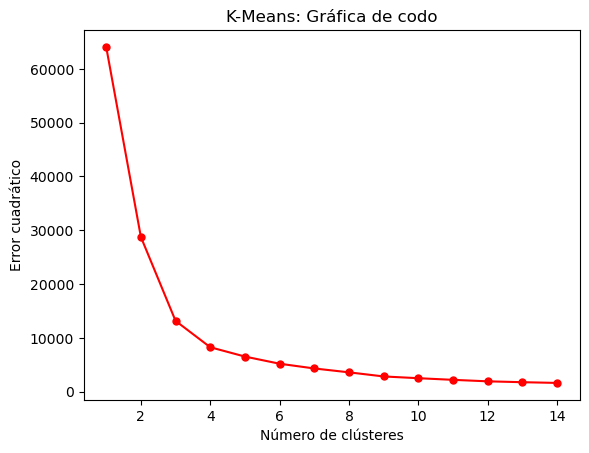

In [78]:
from sklearn.cluster import KMeans
K = range(1,15)

wss = []

for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    
    kmeans = kmeans.fit(df_final_cols[['LONGITUD', 'LATITUD']])
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

centers = pd.DataFrame({'Clusters': K, 'WSS': wss})

import seaborn as sns
plt.plot(centers.Clusters, centers.WSS, 'ro-', markersize = 5)
plt.xlabel('Número de clústeres')
plt.ylabel('Error cuadrático')
plt.title('K-Means: Gráfica de codo')

In [79]:
#Definimos el k óptimo
k = 4

geo_localizacion = df_final_cols[['LONGITUD', 'LATITUD']]

In [80]:
#Entrenamos el modelo
kmeans = KMeans(n_clusters=k).fit(geo_localizacion)

#Buscamos las coordenadas de los centros
centroids = kmeans.cluster_centers_

#Asignamos los clústers a las observaciones
df_final_cols['labels'] = kmeans.labels_

C = kmeans.cluster_centers_.tolist()

C


[[-100.22409355702918, 20.255194079575595],
 [-90.09271577777778, 19.6502625],
 [-111.44537124271844, 28.73401659708738],
 [-103.66051365634675, 24.76775789783282]]

Ahora generemos el dataframe que estaremos utilizando para graficar los centros. También definiremos una columna de "Semaforo", donde registraremos la moda de la calidad del agua para cada clúster.

In [81]:
for i in range(k):
    #Buscamos la moda de cada clúster
    C[i].append(df_final_cols[df_final_cols['labels'] == i][['SEMAFORO']].mode(axis = 0)['SEMAFORO'][0])

df_centers = pd.DataFrame(C, columns = ['Longitud', 'Latitud', 'Semaforo'])
df_centers["Coordinates"] = list(zip(df_centers['Longitud'], df_centers['Latitud']))
df_centers["Coordinates"] = df_centers["Coordinates"].apply(Point)

df_centers

,Longitud,Latitud,Semaforo,Coordinates
0,-100.224094,20.255194,Verde,POINT (-100.22409355702918 20.255194079575595)
1,-90.092716,19.650263,Amarillo,POINT (-90.09271577777778 19.6502625)
2,-111.445371,28.734017,Verde,POINT (-111.44537124271844 28.73401659708738)
3,-103.660514,24.767758,Rojo,POINT (-103.66051365634675 24.76775789783282)


In [82]:
geo_df = gpd.GeoDataFrame(df_centers, geometry="Coordinates") 

Ahora procederemos a generar el gráfico

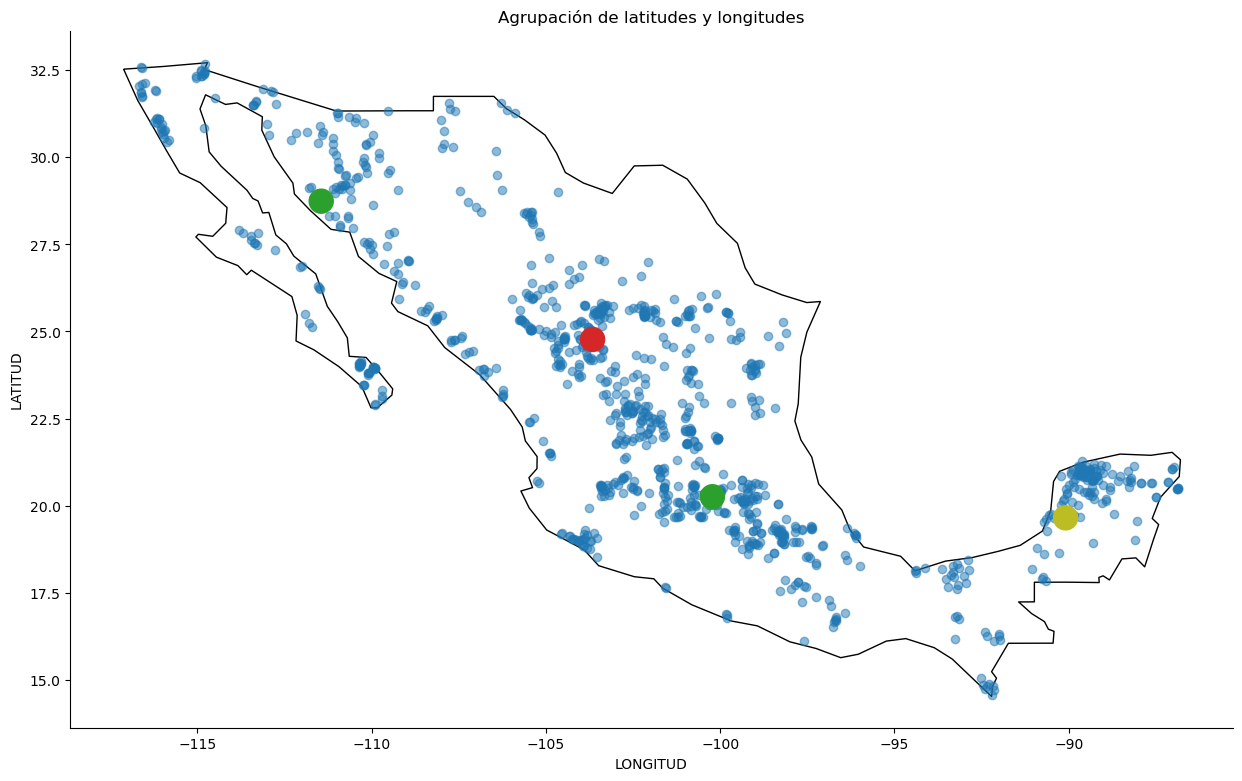

In [83]:
from pandas.core.internals.concat import concat_arrays

fig, gax = plt.subplots(figsize=(15,10))
world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')
gdf.plot(ax=gax, color='tab:blue', alpha = 0.5)
geo_df.plot(ax=gax, color=df_centers.Semaforo.map(color_map), alpha = 1, markersize = 300)

gax.set_xlabel('LONGITUD')
gax.set_ylabel('LATITUD')
gax.set_title('Agrupación de latitudes y longitudes')
gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
plt.show()

Del gráfico anterior se puede observar que el centro de México es la zona con la mayor contaminación de agua, seguido de la zona sur, con una calidad aceptable. Las zonas con más pozos de agua potable se encuentran en la parte norte del país, y al sur del centro de México. Por último, veamos la cantidad de fuetnes de agua por cada clúster.

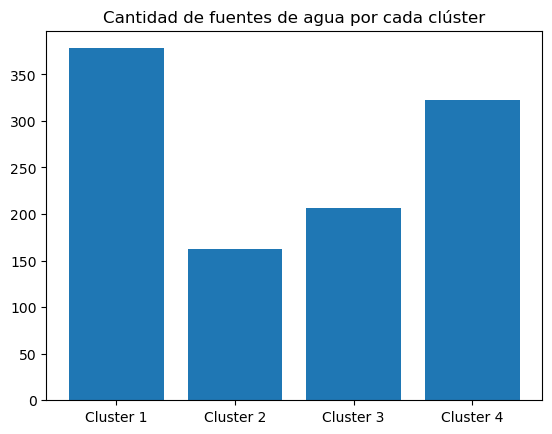

In [84]:
plt.bar(x = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'], 
        height =df_final_cols['labels'].value_counts().sort_index().to_list())  
plt.title('Cantidad de fuentes de agua por cada clúster') 
plt.show()